In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tabulate import tabulate
import seaborn as sns
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## Data Loading

In [2]:
df = pd.read_csv('data.csv', index_col=False)
print("Data Shape: {}".format(df.shape))
df.head()

Data Shape: (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# dropping id if in df
if 'id' in df.columns:
    df = df.drop("id", axis=1) # don't want id to be included as a factor
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# one hot encoding y
le = LabelEncoder()
y = le.fit_transform(y)
# print which class is what
print("Class 0: {}".format(le.inverse_transform([0])))
print("Class 1: {}".format(le.inverse_transform([1])))

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Class 0: ['B']
Class 1: ['M']
X shape: (569, 30)
y shape: (569,)


### Data Exploration

In [4]:
# Understanding ranges of features
tab = []
for col in X.columns:
  row = []
  row.append(col)
  row.append(type(X[col][0]).__name__)

  if isinstance(X[col][0], np.float64):
    row.append("Range: {:.2f} - {:.2f}".format(X[col].min(), X[col].max()))
  else:
    row.append(sorted(X[col].unique().tolist()))

  tab.append(row)

print(tabulate(tab, tablefmt="grid", headers=["Column", "Type", "Values"]))

+-------------------------+---------+-------------------------+
| Column                  | Type    | Values                  |
+=========================+=========+=========================+
| radius_mean             | float64 | Range: 6.98 - 28.11     |
+-------------------------+---------+-------------------------+
| texture_mean            | float64 | Range: 9.71 - 39.28     |
+-------------------------+---------+-------------------------+
| perimeter_mean          | float64 | Range: 43.79 - 188.50   |
+-------------------------+---------+-------------------------+
| area_mean               | float64 | Range: 143.50 - 2501.00 |
+-------------------------+---------+-------------------------+
| smoothness_mean         | float64 | Range: 0.05 - 0.16      |
+-------------------------+---------+-------------------------+
| compactness_mean        | float64 | Range: 0.02 - 0.35      |
+-------------------------+---------+-------------------------+
| concavity_mean          | float64 | Ra

## Evaluation Code

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, results_df, conf_mat=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print metrics
    print("------ {} Results ------".format(model_name))
    print("Accuracy:  {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}%".format(precision * 100))
    print("Recall:    {:.2f}%".format(recall * 100))
    print("F1 Score:  {:.2f}%".format(f1 * 100))
    print("ROC AUC:   {:.2f}%".format(roc_auc * 100))
    print("")

    if conf_mat:
        # Print confusion matrix
        cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    # Add column of metrics to df
    results_df[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

## Baseline Model

------ Logistic Regression Results ------
Accuracy:  97.37%
Precision: 97.62%
Recall:    95.35%
F1 Score:  96.47%
ROC AUC:   99.74%



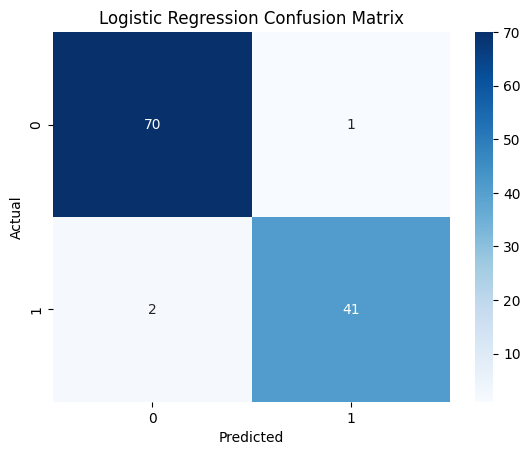

In [6]:
# Creating variables
results_df = pd.DataFrame()
lr = LogisticRegression(max_iter=1000)

# Evaluating basing Logistic Regression model before testing preprocessing techniques
evaluate_model(lr, X_train, y_train, X_test, y_test, "Logistic Regression", results_df)

## Class Imbalance

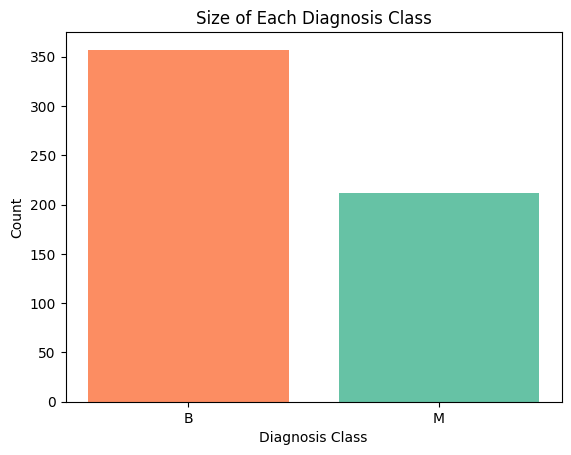

Class: 1; Percentage: 37.26%
Class: 0; Percentage: 62.74%


In [26]:
# Plotting distribution of y classes
counts = Counter(y)
keys = []
for key in counts.keys():
  keys.append(key)

plt.bar(counts.keys(), counts.values(), color=plt.cm.Set2.colors)
plt.title("Size of Each Diagnosis Class")
plt.xlabel("Diagnosis Class")
plt.ylabel("Count")
plt.xticks(keys, le.inverse_transform(keys))
plt.show()

for key in counts.keys():
  print("Class: {};".format(key), "Percentage: {:.2f}%".format(counts[key]/len(y)*100))


In [8]:
min_key = min(counts, key=counts.get)
min_count = counts[min_key]
np.random.seed(0)

# Balancing dataset
bal_ind = []
for key in keys:
  indices = [i for i in range(len(y)) if y[i] == key]
  if key == min_key:
    bal_ind += indices
  else:
    bal_ind += sample(indices, min_count)

X_bal = X.iloc[bal_ind]
y_bal = y[bal_ind]

# Saving balanced dataset
df_bal = pd.concat([X_bal, pd.DataFrame({'diagnosis': y_bal})], axis=1)
df_bal.to_csv("data_balanced.csv", index=False)
print("Balanced Data Shape: {}".format(df_bal.shape))

Balanced Data Shape: (524, 31)


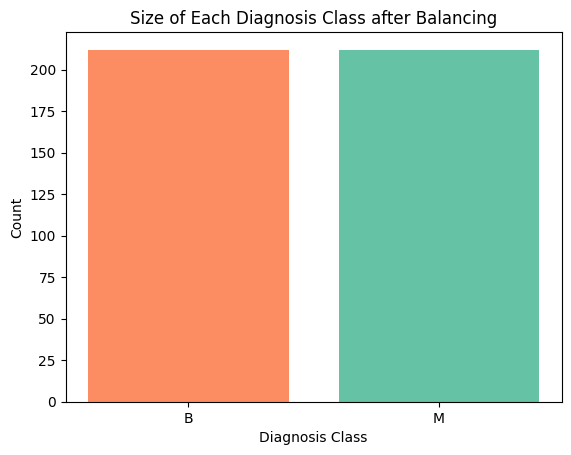

Class: 1; Percentage: 50.00%
Class: 0; Percentage: 50.00%


In [27]:
# Plotting balanced dataset
counts = Counter(y_bal)
keys = []
for key in counts.keys():
  keys.append(key)

plt.bar(counts.keys(), counts.values(), color=plt.cm.Set2.colors)
plt.title("Size of Each Diagnosis Class after Balancing")
plt.xlabel("Diagnosis Class")
plt.ylabel("Count")
plt.xticks(keys, le.inverse_transform(keys))
plt.show()

# Print percentage of each class
for key in counts.keys():
  print("Class: {};".format(key), "Percentage: {:.2f}%".format(counts[key]/len(y_bal)*100))

### Testing Balanced Dataset

In [10]:
# Splitting each dataset
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# scaling data
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test_bal = scaler.transform(X_test_bal)

# evaluating model
evaluate_model(lr, X_train_bal, y_train_bal, X_test_bal, y_test_bal, "Logistic Regression (Balanced)", results_df, False)

------ Logistic Regression (Balanced) Results ------
Accuracy:  94.12%
Precision: 97.67%
Recall:    91.30%
F1 Score:  94.38%
ROC AUC:   99.00%



## Dimensionality Reduction

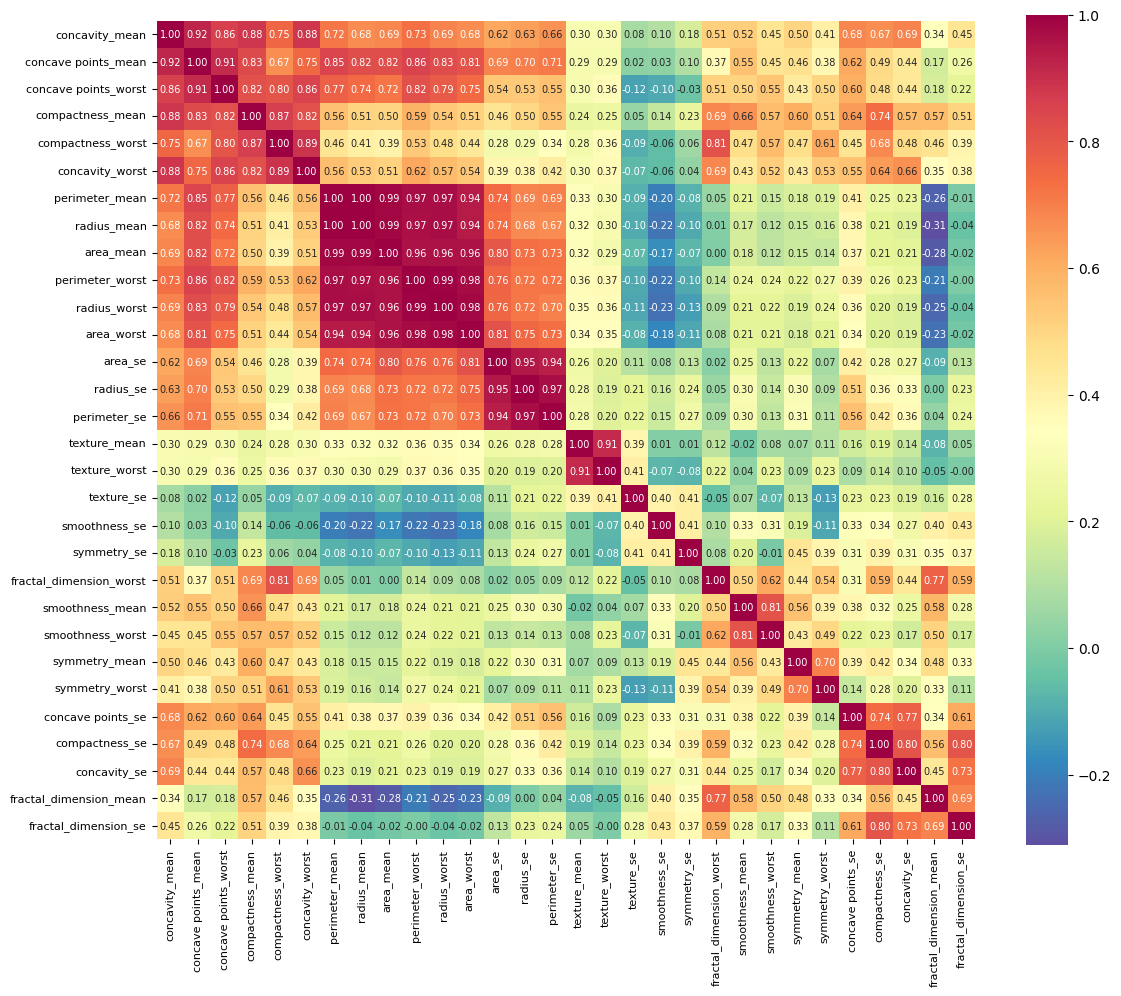

In [11]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# This is to redorder correlation matrix so that highly correlated features are grouped together
linkage_matrix = linkage(correlation_matrix, method='average') # compute the linkage matrix and optimal ordering of features
idx = leaves_list(linkage_matrix)
ordered_corr = correlation_matrix.iloc[idx, :].iloc[:, idx] # reordering matrix

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(ordered_corr, annot=True, cmap="Spectral_r", fmt=".2f", annot_kws={"size": 7}, square=True)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

### Correlation based reduction

In [12]:
# Find feature pairs with correlation ≥ 0.95
tri = correlation_matrix.where(np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1))

high_corr_pairs = tri.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.97]

print(high_corr_pairs)

            Feature1         Feature2  Correlation
1        radius_mean   perimeter_mean     0.997855
2        radius_mean        area_mean     0.987357
57    perimeter_mean        area_mean     0.986507
76    perimeter_mean  perimeter_worst     0.970387
246        radius_se     perimeter_se     0.972794
391     radius_worst  perimeter_worst     0.993708
392     radius_worst       area_worst     0.984015
407  perimeter_worst       area_worst     0.977578


In [13]:
# Removing redundant features (one per group)
X_redundant = X.drop(columns=["perimeter_mean", "radius_se", "area_worst"])
df_redundant = pd.concat([X_redundant, pd.DataFrame({'diagnosis': y})], axis=1)
df_redundant.to_csv("data_redundant.csv", index=False)

print(df_redundant.shape)

(569, 28)


In [14]:
X_redundant_train, X_redundant_test, y_redundant_train, y_redundant_test = train_test_split(X_redundant, y, test_size=0.2, random_state=42)
# scaling data
scaler = StandardScaler()
X_redundant_train = scaler.fit_transform(X_redundant_train)
X_redundant_test = scaler.transform(X_redundant_test)

evaluate_model(lr, X_redundant_train, y_redundant_train, X_redundant_test, y_redundant_test, "Logistic Regression (Redundant)", results_df, False)

------ Logistic Regression (Redundant) Results ------
Accuracy:  97.37%
Precision: 97.62%
Recall:    95.35%
F1 Score:  96.47%
ROC AUC:   99.74%



### Feature importance based reduction

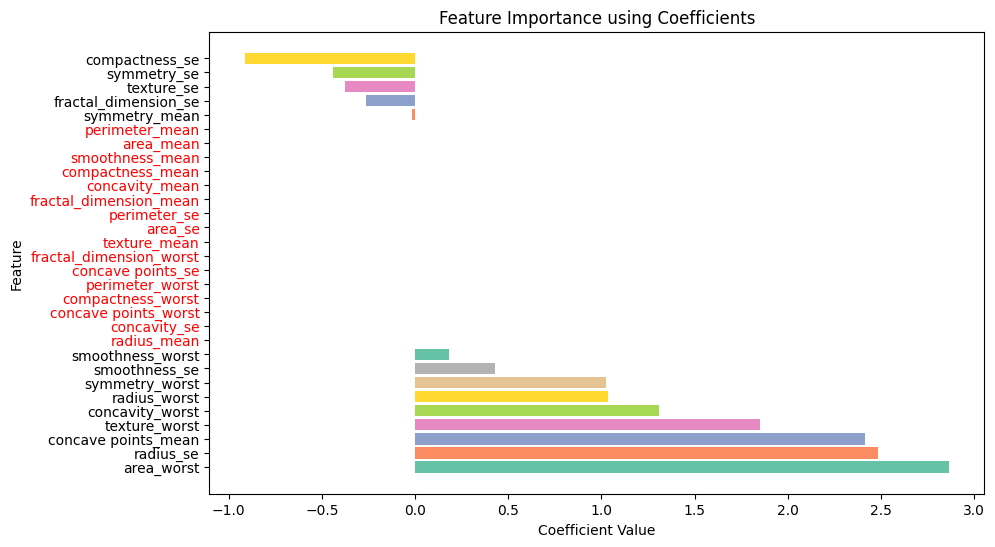

In [15]:
lr_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
lr_l1.fit(X_train, y_train)

# Coefficients Ratios
coefficients = lr_l1.coef_[0]

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=plt.cm.Set2.colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

# Get axis and tick labels
ax = plt.gca()
yticks = ax.get_yticklabels()

# Color labels red if the corresponding coefficient is 0
for label, coef in zip(yticks, feature_importance['Coefficient']):
    if coef == 0: label.set_color('red')

plt.title("Feature Importance using Coefficients")
plt.show()

In [16]:
# removing features with 0 coefficients from original dataset
X_feature_imp = X.loc[:, coefficients != 0]
X_feature_imp = X_feature_imp.reset_index(drop=True)

# Saving reduced dataset
df_feature_imp = pd.concat([X_feature_imp, pd.DataFrame({'diagnosis': y})], axis=1)
df_feature_imp.to_csv("feature_importance_reduction.csv", index=False)

In [17]:
X_feature_imp_train, X_feature_imp_test, y_feature_imp_train, y_feature_imp_test = train_test_split(X_feature_imp, y, test_size=0.2, random_state=42)
X_feature_imp_train = scaler.fit_transform(X_feature_imp_train)
X_feature_imp_test = scaler.transform(X_feature_imp_test)

# Logistic Regression on feature importance dataset
evaluate_model(lr, X_feature_imp_train, y_feature_imp_train, X_feature_imp_test, y_feature_imp_test, "Logistic Regression (Feature Importance)", results_df, False)

------ Logistic Regression (Feature Importance) Results ------
Accuracy:  96.49%
Precision: 95.35%
Recall:    95.35%
F1 Score:  95.35%
ROC AUC:   99.67%



### PCA

Text(0, 0.5, 'Explained Variance Ratio')

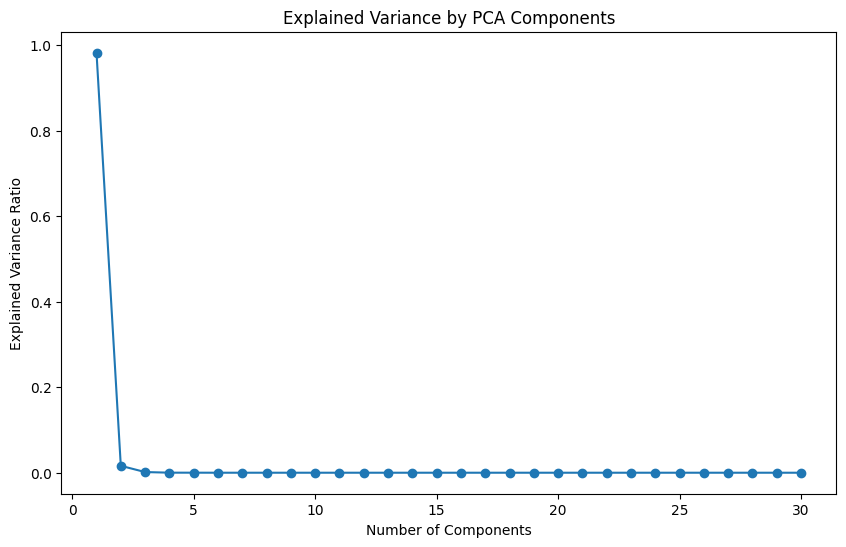

In [18]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)
explained_variance = pca.explained_variance_ratio_

# plotting explained variance with cut in y axis
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")

In [19]:
# keeping first 2 components based on explained variance
X_pca = X_pca[:, :2]

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# scaling data
scaler = StandardScaler()
X_pca_train = scaler.fit_transform(X_pca_train)
X_pca_test = scaler.transform(X_pca_test)

# Logistic Regression on PCA dataset
evaluate_model(lr, X_pca_train, y_pca_train, X_pca_test, y_pca_test, "Logistic Regression (PCA)", results_df, False)

------ Logistic Regression (PCA) Results ------
Accuracy:  93.86%
Precision: 100.00%
Recall:    83.72%
F1 Score:  91.14%
ROC AUC:   99.80%



### LDA

In [20]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
# scaling data
scaler = StandardScaler()
X_lda_train = scaler.fit_transform(X_lda_train)
X_lda_test = scaler.transform(X_lda_test)

# Logistic Regression on LDA dataset
evaluate_model(lr, X_lda_train, y_lda_train, X_lda_test, y_lda_test, "Logistic Regression (LDA)", results_df, False)

------ Logistic Regression (LDA) Results ------
Accuracy:  97.37%
Precision: 97.62%
Recall:    95.35%
F1 Score:  96.47%
ROC AUC:   99.77%



In [21]:
results_df.head()

,Logistic Regression,Logistic Regression (Balanced),Logistic Regression (Redundant),Logistic Regression (Feature Importance),Logistic Regression (PCA),Logistic Regression (LDA)
Accuracy,0.973684,0.941176,0.973684,0.964912,0.938596,0.973684
Precision,0.976190,0.976744,0.976190,0.953488,1.000000,0.976190
Recall,0.953488,0.913043,0.953488,0.953488,0.837209,0.953488
F1 Score,0.964706,0.943820,0.964706,0.953488,0.911392,0.964706
ROC AUC,0.997380,0.989967,0.997380,0.996725,0.998035,0.997707


## KNN

Best K value: 3
------ KNN Results ------
Accuracy:  94.74%
Precision: 93.02%
Recall:    93.02%
F1 Score:  93.02%
ROC AUC:   97.64%



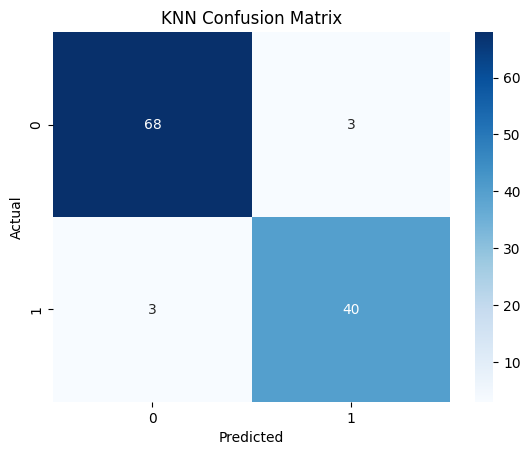

In [22]:
k_vals = list(range(1, 21))
param_grid = {'n_neighbors': k_vals}

# Finding best k value using Grid Search
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
knn_grid_search.fit(X_train, y_train)
best_k = knn_grid_search.best_params_['n_neighbors']
print(f"Best K value: {best_k}")

# Evaluating model with best_k
knn = KNeighborsClassifier(n_neighbors=best_k)
evaluate_model(knn, X_train, y_train, X_test, y_test, "KNN", results_df)

## XGBoost Classifier

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': np.float64(1.6839622641509433)}
------ XGBoost Results ------
Accuracy:  95.61%
Precision: 95.24%
Recall:    93.02%
F1 Score:  94.12%
ROC AUC:   99.28%



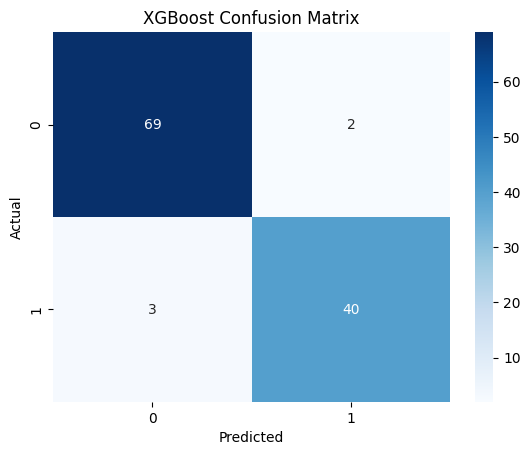

In [23]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, sum(y == 0) / sum(y == 1)]
}

xgb = XGBClassifier(objective='binary:logistic', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
# Evaluating model with best parameters
xgb = XGBClassifier(**best_params, objective='binary:logistic', random_state=42)
evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost", results_df)


In [24]:
results_df.head()

,Logistic Regression,Logistic Regression (Balanced),Logistic Regression (Redundant),Logistic Regression (Feature Importance),Logistic Regression (PCA),Logistic Regression (LDA),KNN,XGBoost
Accuracy,0.973684,0.941176,0.973684,0.964912,0.938596,0.973684,0.947368,0.956140
Precision,0.976190,0.976744,0.976190,0.953488,1.000000,0.976190,0.930233,0.952381
Recall,0.953488,0.913043,0.953488,0.953488,0.837209,0.953488,0.930233,0.930233
F1 Score,0.964706,0.943820,0.964706,0.953488,0.911392,0.964706,0.930233,0.941176
ROC AUC,0.997380,0.989967,0.997380,0.996725,0.998035,0.997707,0.976417,0.992794


In [25]:
# save results
# results_df.to_csv("results.csv", index=False)